In [2]:
import csv
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
import sys
import pandas as pd
import ast
import importlib
import random

sys.path.append('../representation-engineering')
sys.path.append('../representation-engineering/examples/primary_emotions')
sys.path.append('../')
if 'playscript_utils' in sys.modules:
    importlib.reload(sys.modules['playscript_utils'])
else:
    import playscript_utils
if 'utils' in sys.modules:
    importlib.reload(sys.modules['utils'])
else:
    import utils
from playscript_utils import model_name_dict, emotions, filter_csv_by_columns, chat_template, filter_criteria_to_string
from repe import repe_pipeline_registry
repe_pipeline_registry()

from utils import primary_emotions_concept_dataset

/n/holylfs06/LABS/kempner_undergrads/Users/jujipotle/envs/rep_eng_python/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def format_probing_data(probing_data_path, emotions, user_tag, assistant_tag, probing_dataset, stimulis_format, include_character, train_test_split=0.5, positive_negative_train_split=0.5, positive_negative_test_split=0.5, seed=0):
    random.seed(seed)
    filtered_data = filter_csv_by_columns(probing_data_path, {'probing_dataset': probing_dataset})
    if stimulis_format == "rep_e":
        template_str = '{user_tag}Consider the {emotion} of the following scenario:\nScenario: {scenario}\nAnswer:{assistant_tag}'
    elif stimulis_format == "conversation":
        template_str = '{user_tag}Consider the {emotion} of the following conversation:\n{scenario}\nAnswer:{assistant_tag}'
    elif stimulis_format == "simple":
        template_str = '{user_tag}{scenario}{assistant_tag}'
    elif stimulis_format == "no_tags":
        template_str = '{scenario}'
    else:
        raise ValueError(f"Invalid stimulis format: {stimulis_format}")

    data = {}
    for emotion in emotions:
        positive_texts = filtered_data[filtered_data['emotion'] == emotion]['text_example'].tolist()
        negative_texts = filtered_data[filtered_data['emotion'] != emotion]['text_example'].tolist()
        positive_characters = filtered_data[filtered_data['emotion'] == emotion]['character'].tolist()
        negative_characters = filtered_data[filtered_data['emotion'] != emotion]['character'].tolist()
        if include_character:
            positive_emotions = [f"{positive_characters[i]}: {positive_texts[i]}" for i in range(len(positive_texts))]
            negative_emotions = [f"{negative_characters[i]}: {negative_texts[i]}" for i in range(len(negative_texts))]
        else:
            positive_emotions = positive_texts
            negative_emotions = negative_texts
        random.shuffle(positive_emotions)
        random.shuffle(negative_emotions)

        train_positive_count = int(len(positive_emotions) * train_test_split)
        train_total_count = int(train_positive_count / positive_negative_train_split)
        train_negative_count = train_total_count - train_positive_count

        test_positive_count = len(positive_emotions) - train_positive_count
        test_total_count = int(test_positive_count / positive_negative_test_split)
        test_negative_count = test_total_count - test_positive_count
        
        train_data = positive_emotions[:train_positive_count] + negative_emotions[:train_negative_count]
        train_labels = [1] * train_positive_count + [0] * train_negative_count
        test_data = positive_emotions[-test_positive_count:] + negative_emotions[-test_negative_count:]
        test_labels = [1] * test_positive_count + [0] * test_negative_count

        combined_train = list(zip(train_data, train_labels))
        combined_test = list(zip(test_data, test_labels))

        random.shuffle(combined_train)
        random.shuffle(combined_test)

        if combined_train:
            train_data, train_labels = zip(*combined_train)
        else:
            train_data, train_labels = [], []
        
        if combined_test:
            test_data, test_labels = zip(*combined_test)
        else:
            test_data, test_labels = [], []

        formatted_train_data = [template_str.format(emotion=emotion, scenario=d, user_tag=user_tag, assistant_tag=assistant_tag) for d in train_data]
        formatted_test_data = [template_str.format(emotion=emotion, scenario=d, user_tag=user_tag, assistant_tag=assistant_tag) for d in test_data]

        data[emotion] = {
            'train': {'data': formatted_train_data, 'labels': train_labels},
            'test': {'data': formatted_test_data, 'labels': test_labels}
        }

    return data

In [4]:
def get_generated_playscripts(generated_playscripts_path, emotions, user_tag, assistant_tag, stimulis_format, include_character, dialogue_concatenate):
    generated_playscripts = pd.read_csv(generated_playscripts_path)
    dialogue_data = {emotion: {"test": {"data": []}} for emotion in emotions}
    dialogue_data_origins = {emotion: {} for emotion in emotions}
    if stimulis_format == "rep_e":
        template_str = '{user_tag}Consider the {emotion} of the following scenario:\nScenario: {scenario}\nAnswer:{assistant_tag}'
    elif stimulis_format == "conversation":
        template_str = '{user_tag}Consider the {emotion} of the following conversation:\n{scenario}\nAnswer:{assistant_tag}'
    elif stimulis_format == "simple":
        template_str = '{user_tag}{scenario}{assistant_tag}'
    elif stimulis_format == "no_tags":
        template_str = '{scenario}'
    else:
        raise ValueError(f"Invalid stimulis format: {stimulis_format}")
    print(f"Number of rows in generated_playscripts: {len(generated_playscripts)}")
    for premise_id, row in generated_playscripts.iterrows():
        dialogues = ast.literal_eval(row["dialogues"])
        if len(dialogues) != 6:
            print(len(dialogues))
        running_dialogue = ""
        for dialogue_id, dialogue in enumerate(dialogues):
            if include_character:
                character_prefix = "Alice: " if dialogue_id % 2 == 0 else "Bob: "
            else:
                character_prefix = ""
            current_dialogue = character_prefix + dialogue
            if dialogue_concatenate:
                running_dialogue += "\n" if dialogue_id != 0 else ""
                running_dialogue += current_dialogue
                formatted_dialogue = running_dialogue
            else:
                formatted_dialogue = current_dialogue
            for emotion in emotions:
                input_prompt = template_str.format(user_tag=user_tag, emotion=emotion, scenario=formatted_dialogue, assistant_tag=assistant_tag)
                if input_prompt in dialogue_data_origins[emotion]:
                    dialogue_data_origins[emotion][input_prompt].append({"premise id": premise_id, "dialogue id": dialogue_id})
                else:
                    dialogue_data[emotion]['test']['data'].append(input_prompt)
                    dialogue_data_origins[emotion][input_prompt] = [{"premise id": premise_id, "dialogue id": dialogue_id}]
    return dialogue_data, dialogue_data_origins

In [5]:
def get_emotion_rep_readers(emotions, rep_reading_pipeline, train_data, rep_token, hidden_layers, n_difference, direction_method):
    emotion_rep_readers = {}
    for emotion in tqdm(emotions):
        train_inputs = train_data[emotion]['train']['data']
        train_labels = train_data[emotion]['train']['labels']
        rep_reader = rep_reading_pipeline.get_directions(train_inputs=train_inputs, rep_token=rep_token, hidden_layers=hidden_layers, n_difference=n_difference, train_labels=train_labels, direction_method=direction_method)  
        emotion_rep_readers[emotion] = rep_reader
    return emotion_rep_readers

In [6]:
def get_emotion_scores(emotions, emotion_rep_readers, rep_reading_pipeline, test_data, rep_token, hidden_layers):
    emotion_scores = {}
    for emotion in tqdm(emotions):
        test_inputs = test_data[emotion]['test']['data']
        rep_reader = emotion_rep_readers[emotion]
        test_scores = rep_reading_pipeline(inputs=test_inputs, rep_token=rep_token, hidden_layers=hidden_layers, rep_reader=rep_reader, batch_size=32)
        emotion_scores[emotion] = test_scores
    return emotion_scores


In [7]:
def evaluate_classification_accuracy(emotions, emotion_rep_readers, test_data_dict, emotion_scores_dict, hidden_layers, filter_criteria, plot_all_emotions):
    results = {test_probing_dataset: {layer: {} for layer in hidden_layers} for test_probing_dataset in test_data_dict.keys()}
    for test_probing_dataset in test_data_dict.keys():
        emotion_scores = emotion_scores_dict[test_probing_dataset]
        for layer in hidden_layers:
            for emotion in emotions:
                test_labels = test_data_dict[test_probing_dataset][emotion]['test']['labels']
                sign = emotion_rep_readers[emotion].direction_signs[layer].item()
                if sign != 1:
                    print("sign != 1, sign =", sign)

                # Absolute zero boundary
                scores_signed = [score[layer] * sign for score in emotion_scores[emotion]]
                cors = np.mean([(scores_signed[i] > 0) == (test_labels[i] == 1) for i in range(len(scores_signed))])
                results[test_probing_dataset][layer][emotion] = cors

    colors = ['blue', 'orange', 'purple', 'cyan', 'yellow', 'brown', 'magenta', 'gray', 'navy', 'teal', 'gold', 'darkorange', 'darkblue', 'lightcoral']
    color_index = 0
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    for test_probing_dataset in test_data_dict.keys():
        x_layers = list(results[test_probing_dataset].keys())
        y_accuracy_mean = [np.mean([results[test_probing_dataset][layer][emotion] for emotion in emotions]) for layer in results[test_probing_dataset]]
        ax.plot(x_layers, y_accuracy_mean, label=f"{test_probing_dataset}: mean={y_accuracy_mean[-1]:.3f}", color=colors[color_index])
        color_index += 1
        if plot_all_emotions:
            for emotion in emotions:
                y_accuracy = [results[test_probing_dataset][layer][emotion] for layer in results[test_probing_dataset]]
                ax.plot(x_layers, y_accuracy, label=f"{test_probing_dataset}: {emotion}={y_accuracy[-1]:.3f}", color=colors[color_index])
                color_index += 1

    ax.set_title(f"Emotions Acc")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Acc")
    ax.set_ylim(0.5, 1.01)
    ax.legend(loc="best")
    ax.grid(True)
    filter_criteria_display = filter_criteria_to_string(filter_criteria, "display")
    filter_criteria_file_name = filter_criteria_to_string(filter_criteria, "file_name")
    fig.suptitle(f"Emotion classification with {filter_criteria_display}", wrap=True)

    plt.tight_layout()
    plt.show()
    output_path = f"../results/emotion_classification_accuracy/{filter_criteria_file_name}.png"
    fig.savefig(output_path)

In [8]:
def get_emotion_inputs_and_scores(emotions, emotion_rep_readers, emotion_scores, test_data, probing_layer):
    emotion_inputs_and_scores = {emotion: [] for emotion in emotions}
    for emotion in emotions:
        sign = emotion_rep_readers[emotion].direction_signs[probing_layer].item()
        if sign != 1:
            print("sign != 1, sign =", sign)
        test_scores_signed = [score[probing_layer] * sign for score in emotion_scores[emotion]]
        test_inputs = test_data[emotion]['test']['data']
        for i in range(len(test_inputs)):
            emotion_inputs_and_scores[emotion].append((test_inputs[i], test_scores_signed[i]))
    return emotion_inputs_and_scores

In [9]:
def write_emotion_scores(generated_playscripts_path, emotion_metrics_path, emotions, dialogue_data_origins, emotion_inputs_and_scores, probing_model_name, probing_method, probing_layer, probing_dataset, stimulis_format, include_character, dialogue_concatenate):
    df = pd.read_csv(generated_playscripts_path)

    # Initialize the new columns
    df['probing_model'] = [probing_model_name for _ in range(len(df))]
    df['probing_method'] = [probing_method for _ in range(len(df))]
    df['probing_layer'] = [probing_layer for _ in range(len(df))]
    df['probing_dataset'] = [probing_dataset for _ in range(len(df))]
    df['stimulis_format'] = [stimulis_format for _ in range(len(df))]
    df['include_character'] = [include_character for _ in range(len(df))]
    df['dialogue_concatenate'] = [dialogue_concatenate for _ in range(len(df))]
    df['emotion_scores'] = [{} for _ in range(len(df))]
    
    # Populate the df with emotion_scores = {happiness: [0, 0, 0, 0, 0, 0], ...} for each playscript
    for i in range(len(df)):
        dialogues_length = df.at[i, 'dialogues_length']
        for emotion in emotions:
            df.at[i, 'emotion_scores'][emotion] = [0] * dialogues_length

    # Write Alice and Bob's emotion scores
    for emotion in emotions:
        for input, score in emotion_inputs_and_scores[emotion]:
            origin_info = dialogue_data_origins[emotion][input]
            for match in origin_info:
                premise_id = match["premise id"]
                dialogue_id = match["dialogue id"]
                df.at[premise_id, 'emotion_scores'][emotion][dialogue_id] = score
    df = df.astype(str)
    df.to_csv(emotion_metrics_path, mode='a', index=False, header=True)

In [10]:
def sweep_emotion_classification_accuracy(probing_data_path, emotions, probing_model_names, probing_methods, train_probing_datasets, test_probing_datasets, stimulis_formats, include_characters, train_test_split, positive_negative_train_split, positive_negative_test_split, seed, plot_all_emotions, plot_train_accuracy):
    for probing_model_name in probing_model_names:
        user_tag, assistant_tag = chat_template(probing_model_name)
        probing_model_HF = model_name_dict[probing_model_name]
        probing_model = AutoModelForCausalLM.from_pretrained(probing_model_HF, torch_dtype=torch.float16, device_map="auto", token=True).eval()
        tokenizer = AutoTokenizer.from_pretrained(probing_model_HF, padding_side="left", legacy=False, token=True)
        tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
        tokenizer.bos_token_id = 1
        rep_reading_pipeline = pipeline("rep-reading", model=probing_model, tokenizer=tokenizer)
        rep_token = -1
        hidden_layers = list(range(0, probing_model.config.num_hidden_layers))
        # hidden_layers = [probing_model.config.num_hidden_layers - 1]
        for probing_method in probing_methods:
            if probing_method == "pca":
                n_difference = 1
            elif probing_method == "logistic_regression":
                n_difference = 0
            for train_probing_dataset in train_probing_datasets:
                for stimulis_format in stimulis_formats:
                    for include_character in include_characters:
                        filter_criteria = {"probing_model": probing_model_name, "probing_method": probing_method, "train_probing_dataset": train_probing_dataset, "stimulis_format": stimulis_format, "include_character": include_character}
                        print(filter_criteria_to_string(filter_criteria, "display"))
                        test_data_dict = {}
                        emotion_scores_dict = {}

                        # Training the probe
                        train_data = format_probing_data(probing_data_path, emotions, user_tag, assistant_tag, train_probing_dataset, stimulis_format, include_character, train_test_split, positive_negative_train_split, positive_negative_test_split, seed)
                        print("Getting emotion rep readers")
                        emotion_rep_readers = get_emotion_rep_readers(emotions, rep_reading_pipeline, train_data, rep_token, hidden_layers, n_difference, probing_method)

                        # Score probe on train data
                        if plot_train_accuracy:
                            print(f"Scoring probe on train_probing_dataset: {train_probing_dataset}")
                            train_data_for_testing = {emotion: {'test': train_data[emotion]['train']} for emotion in emotions}
                            test_data_dict[f"{train_probing_dataset}_train"] = train_data_for_testing
                            emotion_scores_dict[f"{train_probing_dataset}_train"] = get_emotion_scores(emotions, emotion_rep_readers, rep_reading_pipeline, train_data_for_testing, rep_token, hidden_layers)

                        # Score probe on test data
                        for test_probing_dataset in test_probing_datasets:
                            if test_probing_dataset == train_probing_dataset:
                                # So we don't accidentally test on data in the train probing dataset (so we use the same train_test_split we used while training the probe)
                                temp_train_test_split = train_test_split
                            else:
                                # All the data can be used for testing
                                temp_train_test_split = 0
                            test_data = format_probing_data(probing_data_path, emotions, user_tag, assistant_tag, test_probing_dataset, stimulis_format, include_character, temp_train_test_split, positive_negative_train_split, positive_negative_test_split, seed)
                            test_data_dict[f"{test_probing_dataset}_test"] = test_data

                            print(f"Scoring probe on test_probing_dataset: {test_probing_dataset}")
                            emotion_scores_dict[f"{test_probing_dataset}_test"] = get_emotion_scores(emotions, emotion_rep_readers, rep_reading_pipeline, test_data, rep_token, hidden_layers)


                        evaluate_classification_accuracy(emotions, emotion_rep_readers, test_data_dict, emotion_scores_dict, hidden_layers, filter_criteria, plot_all_emotions)

In [11]:
def sweep_emotion_scoring(probing_data_path, generated_playscripts_path, emotion_metrics_path, emotions, probing_model_names, probing_methods, probing_layers, train_probing_datasets, stimulis_formats, include_characters, dialogue_concatenates, positive_negative_train_split, seed):
    train_test_split = 1.0 # To maximize data used for training the probe, since we're getting our test data from generated playscripts
    positive_negative_test_split = 1.0 # Doesn't matter what this is as long as it's non-zero, since we won't have test data
    for probing_model_name in probing_model_names:
        user_tag, assistant_tag = chat_template(probing_model_name)
        probing_model_HF = model_name_dict[probing_model_name]
        probing_model = AutoModelForCausalLM.from_pretrained(probing_model_HF, torch_dtype=torch.float16, device_map="auto", token=True).eval()
        tokenizer = AutoTokenizer.from_pretrained(probing_model_HF, padding_side="left", legacy=False, token=True)
        tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
        tokenizer.bos_token_id = 1
        rep_reading_pipeline = pipeline("rep-reading", model=probing_model, tokenizer=tokenizer)
        rep_token = -1        
        for probing_method in probing_methods:
            if probing_method == "pca":
                n_difference = 1
            elif probing_method == "logistic_regression":
                n_difference = 0
            for train_probing_dataset in train_probing_datasets:
                for probing_layer in probing_layers:
                    hidden_layers = [probing_layer]
                    for stimulis_format in stimulis_formats:
                        for include_character in include_characters:
                            filter_criteria = {"probing_model": probing_model_name, "probing_method": probing_method, "train_probing_dataset": train_probing_dataset, "stimulis_format": stimulis_format, "include_character": include_character}
                            print(filter_criteria_to_string(filter_criteria, "display"))
                            train_data = format_probing_data(probing_data_path, emotions, user_tag, assistant_tag, train_probing_dataset, stimulis_format, include_character, train_test_split, positive_negative_train_split, positive_negative_test_split, seed)
                            print(f"Getting emotion rep readers")
                            emotion_rep_readers = get_emotion_rep_readers(emotions, rep_reading_pipeline, train_data, rep_token, hidden_layers, n_difference, probing_method)
                            for dialogue_concatenate in dialogue_concatenates:
                                dialogue_data, dialogue_data_origins = get_generated_playscripts(generated_playscripts_path, emotions, user_tag, assistant_tag, stimulis_format, include_character, dialogue_concatenate)
                                print(f"Scoring probe on playscripts with dialogue_concatenate: {dialogue_concatenate}")
                                dialogue_emotion_scores = get_emotion_scores(emotions, emotion_rep_readers, rep_reading_pipeline, dialogue_data, rep_token, hidden_layers)
                                dialogue_emotion_inputs_and_scores = get_emotion_inputs_and_scores(emotions, emotion_rep_readers, dialogue_emotion_scores, dialogue_data, probing_layer)
                                write_emotion_scores(generated_playscripts_path, emotion_metrics_path, emotions, dialogue_data_origins, dialogue_emotion_inputs_and_scores, probing_model_name, probing_method, probing_layer, train_probing_dataset, stimulis_format, include_character, dialogue_concatenate)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 3/3 [00:18<00:00,  6.12s/it]


probing_model: llama2_13b_chat, probing_method: logistic_regression, train_probing_dataset: playscript_neutral_train, stimulis_format: simple, include_character: False
Getting emotion rep readers


100%|██████████| 6/6 [00:38<00:00,  6.49s/it]


Scoring probe on test_probing_dataset: playscript_neutral_test


100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


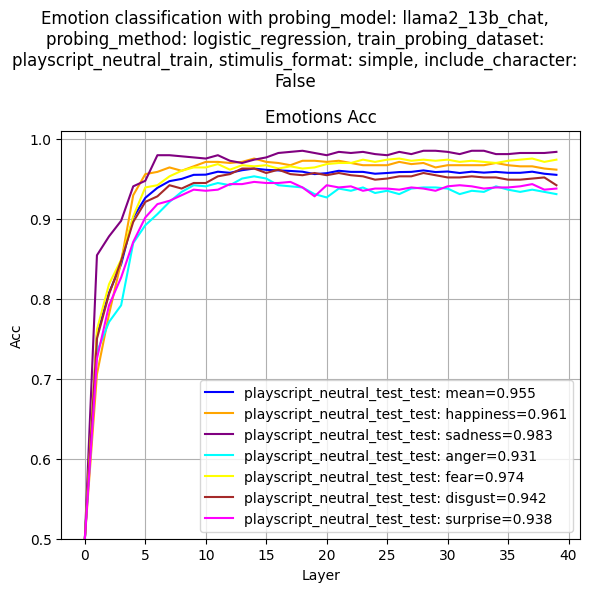

In [13]:
probing_data_path = "../data/permanent/emotion_probing_data.csv"
generated_playscripts_path = "../data/permanent/generated_playscripts.csv"
emotion_metrics_path = "../data/permanent/emotion_metrics_new_new.csv"
probing_model_names = ["llama2_13b_chat"]
probing_methods = ["logistic_regression"]
probing_layers = [39]
train_probing_datasets = ["playscript_neutral_train"]
test_probing_datasets = ["playscript_neutral_test"]
train_test_split = 1.0
positive_negative_train_split = 0.5
positive_negative_test_split = 0.5
stimulis_formats = ["simple"]
include_characters = [False]
dialogue_concatenates = [False]
plot_all_emotions = True
plot_train_accuracy = False
seed = 0
# sweep_emotion_scoring(probing_data_path, generated_playscripts_path, emotion_metrics_path, emotions, probing_model_names, probing_methods, probing_layers, train_probing_datasets, stimulis_formats, include_characters, dialogue_concatenates, positive_negative_train_split, seed)
sweep_emotion_classification_accuracy(probing_data_path, emotions, probing_model_names, probing_methods, train_probing_datasets, test_probing_datasets, stimulis_formats, include_characters, train_test_split, positive_negative_train_split, positive_negative_test_split, seed, plot_all_emotions, plot_train_accuracy)
